This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [111]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Local imports
import sys
sys.path.append('../../../../')
import stlstuff as sls
import imagestuff as ims
import facetbrightnessstuff9 as fbs
import f90nml
import gradstuff as gds

In [112]:
%matplotlib notebook

In [113]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments'
imageroot = '2018-07-25_2.0'
Calibrationfile = '../Case2.0 (calibration)/Calibration.nml'

/Users/chemistry/Desktop/Lincoln2018/Ivana/Crystals/2018-07-25/Case2.0 (calibration)
hemistry/Desktop/Lincoln2018/Ivana/Crystals/2018-07-25/Case2.0 (calibration)


In [114]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments_retrieved.npz
Segments_roughness.jpg
Segments_roughness.txt


In [115]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'retrieved'

In [116]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

Filename, dx and dy SEMimages/2018-07-25_2.0-D.bmp 0.2834821 0.2834821


<IPython.core.display.Javascript object>


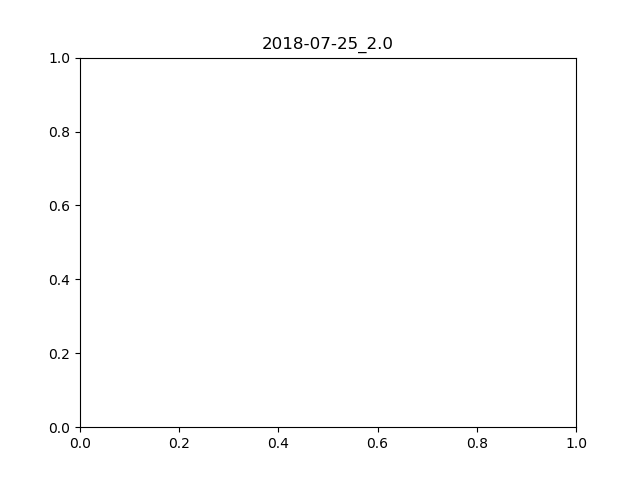

In [117]:
# Show just the image (in case we want to look at it before defining the segments)
im = PIL.Image.open(Filename)
plt.figure()
plt.title(imageroot)
plt.show(im,cmap = 'Greys_r', vmin = 0,vmax = 255)
im.show() # This shouldn't be necessary but there seems to be a bug with plt.show

<IPython.core.display.Javascript object>


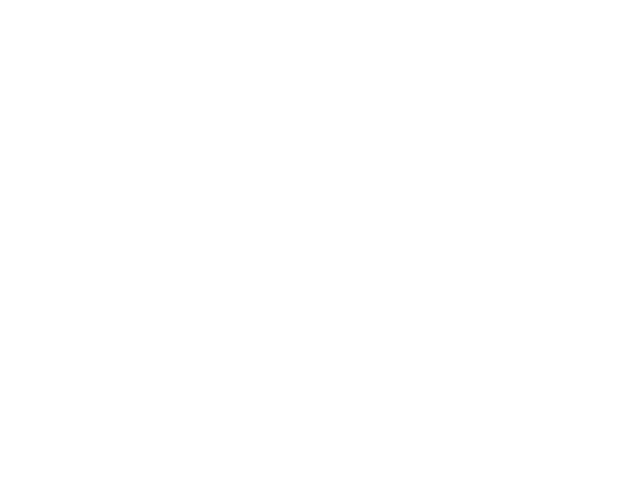

In [118]:
# Extract
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)

# Show it
plt.figure()
plt.show(im,cmap = 'Greys_r', vmin = 0,vmax = 255)
im.show() # This shouldn't be necessary but there seems to be a bug with plt.show

# Save a copy
im.save(SEMSegmentjpgfile)

In [119]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']


../Case2.0 (calibration)/Calibration.nml


In [120]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [121]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [122]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
fbs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [123]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [124]:
# Generic retrieval parameters
maxiter = 5
tolerance = 10

In [125]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
noiseamp = 5.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 2.23606797749979
Std deviation in a priori is 15.0


In [126]:
# Loop to retrieve each segment
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    vartemp_long = np.reshape(vartemp,nzpts+1,0)
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("for", nx1, ny1)
    print("Segment:", isegment+1, "of", nsegments)
    z_retrieved = fbs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


for 590 270
Segment: 1 of 64
Observed intensities (detector B):
mean, max, min = 41.238125 47.0 34.0
<diff>, std(diff), di2 = 1.42478739891324 4.628725243063014 23557.829002816463
<diff>, std(diff), di2 = 0.9543032384437029 2.0750261908960255 867.2490957109067
<diff>, std(diff), di2 = 0.8370774149182519 1.9523242706356851 50.099271740613
<diff>, std(diff), di2 = 0.8118514060267445 1.949589850017605 5.306949770047131

for 590 310
Segment: 2 of 64
Observed intensities (detector B):
mean, max, min = 41.45125 48.0 34.0
<diff>, std(diff), di2 = 1.7340061489132401 4.765953287867113 25534.011923636186
<diff>, std(diff), di2 = 1.1942612757100186 2.10621484293869 1043.8249780451915
<diff>, std(diff), di2 = 1.053658033287842 1.9740204306049598 68.77735942377957
<diff>, std(diff), di2 = 1.0179743915869066 1.9747216479962177 6.5025787411237275
Noverlap = 41

for 590 350
Segment: 3 of 64
Observed intensities (detector B):
mean, max, min = 42.310625 52.0 35.0
<diff>, std(diff), di2 = 1.442756148913

<diff>, std(diff), di2 = 0.7212482437962539 1.8382337674963627 7.146705656465028
Noverlap = 84

for 670 390
Segment: 20 of 64
Observed intensities (detector B):
mean, max, min = 41.618125 50.0 35.0
<diff>, std(diff), di2 = 1.62666239891324 4.959364319713461 28081.84405502572
<diff>, std(diff), di2 = 1.1623952069999988 2.0526502752433395 1333.0832881235467
<diff>, std(diff), di2 = 1.0154926691199493 1.861018992910757 93.3142824105222
<diff>, std(diff), di2 = 0.9714938025031418 1.8589179645479565 6.345351357696385
Noverlap = 84

for 670 430
Segment: 21 of 64
Observed intensities (detector B):
mean, max, min = 41.778125 48.0 36.0
<diff>, std(diff), di2 = 1.78759989891324 4.972911851049226 28378.396475436104
<diff>, std(diff), di2 = 1.3150639860018476 2.0523521803659897 1402.6787925526123
<diff>, std(diff), di2 = 1.163581604795718 1.8582315737298971 106.46843353529714
<diff>, std(diff), di2 = 1.1158807823667265 1.8577595121163049 9.1313219418757
Noverlap = 84

for 670 470
Segment: 22 of 64

<diff>, std(diff), di2 = 1.1486304206832667 2.093157593668919 1553.828496882206
<diff>, std(diff), di2 = 0.9895733965649162 1.8645872815676658 126.28653183799719
<diff>, std(diff), di2 = 0.936438810094209 1.8570860476040336 11.25217165372314
<diff>, std(diff), di2 = 0.9246422527338871 1.858472192940354 2.2809643938190707
Noverlap = 84

for 750 470
Segment: 38 of 64
Observed intensities (detector B):
mean, max, min = 41.8575 49.0 35.0
<diff>, std(diff), di2 = 1.8460373989132401 5.033546283738724 29280.11953176194
<diff>, std(diff), di2 = 1.3779205232748633 2.0461381603533457 1539.579821769276
<diff>, std(diff), di2 = 1.2207066943598721 1.8324358678100605 125.81489865782356
<diff>, std(diff), di2 = 1.1680526311737183 1.8314426984863779 10.070735965074974
<diff>, std(diff), di2 = 1.1561807062595735 1.834770871020096 1.071860963883425
Noverlap = 84

for 750 510
Segment: 39 of 64
Observed intensities (detector B):
mean, max, min = 41.89375 50.0 35.0
<diff>, std(diff), di2 = 1.90322489891324

<diff>, std(diff), di2 = 1.1016673316891934 1.8392872109528196 9.480354823368813
Noverlap = 84

for 830 510
Segment: 55 of 64
Observed intensities (detector B):
mean, max, min = 41.85125 48.0 36.0
<diff>, std(diff), di2 = 1.95228739891324 5.139938353408523 30615.838572274646
<diff>, std(diff), di2 = 1.475098687607625 2.0951051952998614 1713.0518500243156
<diff>, std(diff), di2 = 1.3074745061630089 1.8666023336060358 152.78462541872628
<diff>, std(diff), di2 = 1.2471212015880153 1.8656224352319528 14.137648048449195
<diff>, std(diff), di2 = 1.2319303735063216 1.869953508774708 1.9863147406340285
Noverlap = 84

for 830 550
Segment: 56 of 64
Observed intensities (detector B):
mean, max, min = 42.13875 49.0 36.0
<diff>, std(diff), di2 = 2.2122873989132406 5.100022655525375 30254.322975724914
<diff>, std(diff), di2 = 1.7324288350505384 2.0891601262406434 1787.1815088942037
<diff>, std(diff), di2 = 1.562277583693788 1.865449999721447 180.56704708311537
<diff>, std(diff), di2 = 1.497151630392

320
320


<IPython.core.display.Javascript object>


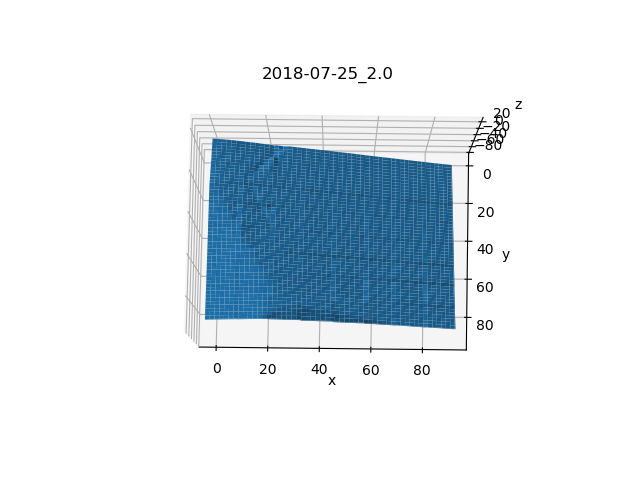

In [129]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=6,cstride=6)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [130]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving Segmentsretrieved
